In [3]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [2]:
%load_ext autoreload
%autoreload 2

# Ionization front ODE

R is in proper Mpc

$$ \frac{dR^3}{dt} = 3 H(z) R^3 + \frac{3 \dot{N}_{ion}}{4\pi n_H} - C n_H \alpha_B R^3$$

$\alpha_B = 2.59\times^{-13}$ cm^3/s (Draine p. 138, table 14.1)

## For David Sobral --- what happens if you neglect recombinations and Hubble expansion?

- If $z>8$ large Hubble expansion, but recombination rate is high --> bubbles smaller than Cen & Haiman
- $z<8$ low recombination rate, but still Hubble expansion --> bubbles a little bigger than CH


# Contribution of each part of Eqn

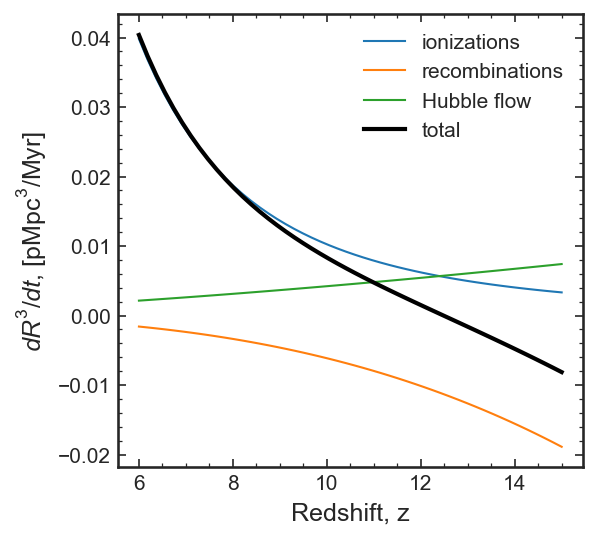

In [21]:
ztab = np.linspace(6, 15.)

horizon = (const.c/Planck15.H(z=ztab)).to(u.Mpc)

R = 1.*u.Mpc
Ndot_ion = 1.e55/u.s

dRdt_ion = bubbles.ionization_front_ionizations(ztab, Ndot_ion=Ndot_ion)
dRdt_rec = bubbles.ionization_front_recombinations(ztab, R=R)
dRdt_Hub = bubbles.ionization_front_Hubble(ztab, R=R)

plt.plot(ztab, dRdt_ion.to(u.Mpc**3/u.Myr), lw=1, label='ionizations')
plt.plot(ztab, dRdt_rec.to(u.Mpc**3/u.Myr), lw=1, label='recombinations')
plt.plot(ztab, dRdt_Hub.to(u.Mpc**3/u.Myr), lw=1, label='Hubble flow')

plt.plot(ztab, (dRdt_ion + dRdt_rec + dRdt_Hub).to(u.Mpc**3/u.Myr), c='k', label='total')

plt.xlabel('Redshift, z')
plt.ylabel('$dR^3/dt$, [pMpc$^3$/Myr]')

plt.legend()

Text(0, 0.5, 'H(z) [km/s/Mpc]')

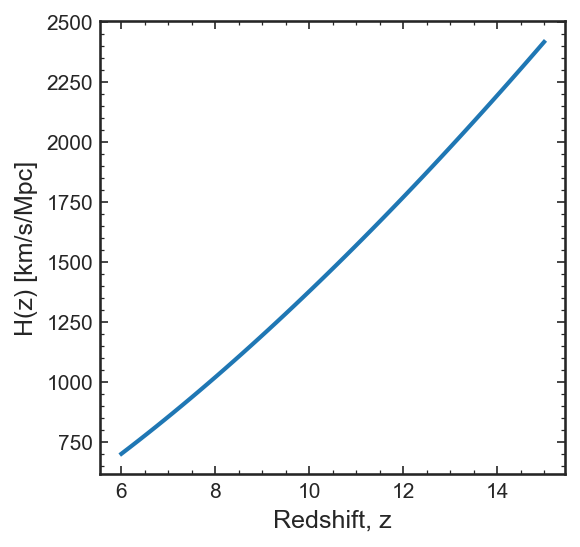

In [20]:
plt.plot(ztab, Planck15.H(ztab))
plt.xlabel('Redshift, z')
plt.ylabel('H(z) [km/s/Mpc]')

# Compare to Cen & Haiman bubble growth - different source Nion

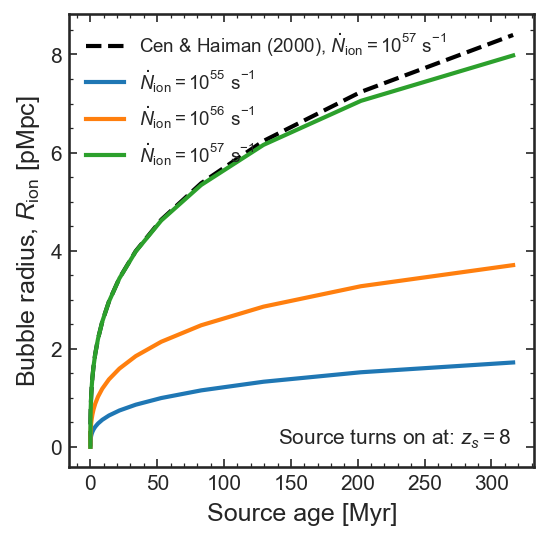

In [25]:
t_tab = np.linspace(0, 3e8)
t_tab = np.logspace(-1, 8.5)

z_s0 = 8 # Redshift source turned on

Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

plt.plot(t_tab/1e6, bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=1.e57/u.s, t_source=t_tab*u.yr), 
         ls='dashed', c='k', label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{57}$ s$^{-1}$')

for Ndot_ion_i in Ndot_ion_tab:
            
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion_i), tfirst=True)
    R = R3.T[0]**(1/3.)
    
    plt.plot(t_tab/1e6, R, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion_i.value)) 
        
plt.annotate('Source turns on at: $z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')
    
plt.xlabel('Source age [Myr]')
plt.ylabel(r'Bubble radius, $R_\mathrm{ion}$ [pMpc]')
    
plt.legend(fontsize=9)

# Compare Cen & Haiman, recombinations + growth

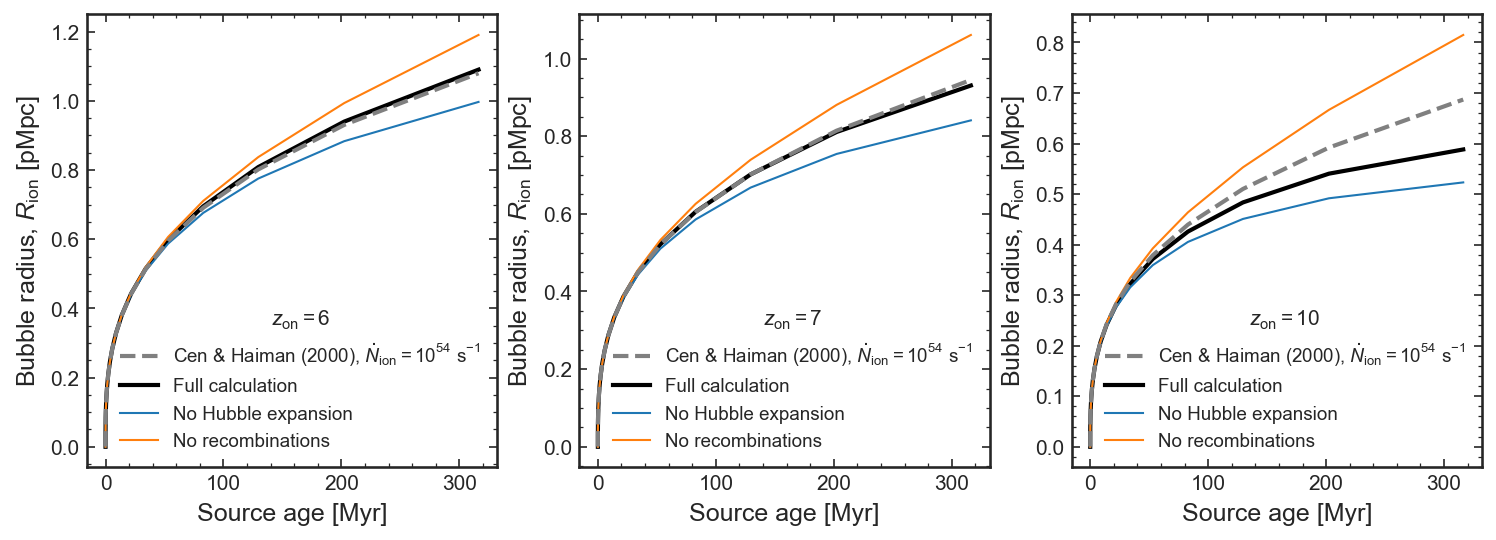

In [38]:
t_tab = np.logspace(-1, 8.5)
Ndot_ion = 1e54/u.s

fig, ax = plt.subplots(1,3, figsize=(12,4))

z_s0_tab = [6, 7, 10] # Redshift source turned on

for i, z_s0 in enumerate(z_s0_tab):
    ax[i].plot(t_tab/1e6, bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=Ndot_ion, t_source=t_tab*u.yr), 
             ls='dashed', c='0.5', zorder=10, label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{54}$ s$^{-1}$')

    # Full calculation
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)
    R = R3.T[0]**(1/3.)
    ax[i].plot(t_tab/1e6, R, c='k', label='Full calculation')

    # No Hubble expansion
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion, 3, 1e4, False, True), tfirst=True)
    R = R3.T[0]**(1/3.)
    ax[i].plot(t_tab/1e6, R, lw=1, label='No Hubble expansion')

    # No recombinations
    R3 = odeint(bubbles.dRion3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion, 3, 1e4, True, False), tfirst=True)
    R = R3.T[0]**(1/3.)
    ax[i].plot(t_tab/1e6, R, lw=1, label='No recombinations')

    ax[i].set_xlabel('Source age [Myr]')
    ax[i].set_ylabel(r'Bubble radius, $R_\mathrm{ion}$ [pMpc]')

    ax[i].legend(loc='lower right', fontsize=9, title='$z_\mathrm{on} = %.0f$' % z_s0)

# VR7

In [27]:
(217.*u.km/u.s/Planck15.H(z=6.6)).to(u.Mpc)

<Quantity 0.27412685 Mpc>

## When did source turn on?

In [31]:
t_age = 1e7*u.yr
zobs = 6.6

t_on = Planck15.age(zobs) - t_age
z_on = z_at_value(Planck15.age, t_on)
z_on

6.6621561625055365